In [1]:
import math
import pandas as pd 
from collections import Counter

### Loading the dataset

In [2]:
data_path = "../data/spam.csv"
df = pd.read_csv(data_path)

In [3]:
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Bernoulli Naive Bayes

In [4]:
class BernoulliNB:
    def __init__(self, num_classes, laplace_smoothing = 0.5, is_imbalance = True):
        self.num_classes = num_classes
        self.is_imbalance = is_imbalance
        self.laplace_smoothing = laplace_smoothing
        
    def preprocess(self, X):
        tokens = self.split_into_tokens(X)
        tokens = map(str.lower, filter(str.isalnum, tokens))
        return list(tokens)
    
    def split_into_tokens(self, sentence):
        return sentence.split(" ")
        
    def fit(self, X, y):
        assert len(set(y)) == self.num_classes, f'{self.num_classes} do not match with the classes present in the dataset.'
                
        # Building the vocabulary
        self.corpus = {}
        self.total_records = len(y)
        for sentence, label in zip(X, y):
            sentence_tokens = self.preprocess(sentence)
            if label not in self.corpus:
                self.corpus[label] = sentence_tokens
                continue 
            self.corpus[label].extend(sentence_tokens)          

        # computing the frequecy 
        self.corpus = {k : Counter(v) for k, v in self.corpus.items()}
        self.labelCount = Counter(y)
    
    def predict(self, X):
        # preprocessing the sentence
        X = self.preprocess(X)
        
        conditional_prob = {}
        for potential_label, total in self.labelCount.items():
            # computing log probabilities for numerical stability
            # log(a * b) = log(a) + log(b)
            log_prob = 1 if self.is_imbalance else math.log(self.labelCount[potential_label] / self.total_records)
            for token in X:
                log_prob += (self.corpus[potential_label][token] + self.laplace_smoothing)/ \
                    (total + (self.num_classes * self.laplace_smoothing))

            conditional_prob[potential_label] =  log_prob        
        return max(conditional_prob, key=conditional_prob.get), conditional_prob

### Training, Hyper-parameter tuning and Validation

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [6]:
X = df.v2.tolist()
y = df['v1'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)

In [7]:
performances = []

alpha = list(range(1, 100, 2))
for val in alpha:
    nb = BernoulliNB(num_classes = 2, laplace_smoothing = val, is_imbalance = False)
    nb.fit(X_train, y_train)
    
    predictions = [nb.predict(test)[0] for test in X_test]
    perf = accuracy_score(y_test, predictions)    
    performances.append(perf)

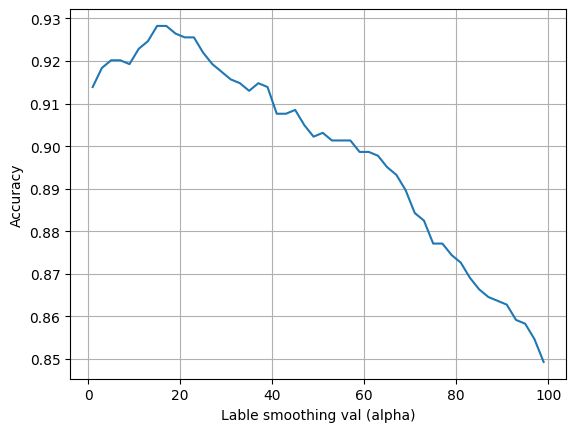

In [8]:
plt.plot(list(range(1, 100, 2)), performances);
plt.grid(True);
plt.ylabel("Accuracy");
plt.xlabel("Lable smoothing val (alpha)");

### Best Model

In [21]:
main_nb = BernoulliNB(num_classes = 2, laplace_smoothing = 18, is_imbalance = False)
main_nb.fit(X_train, y_train)

In [22]:
predictions = [main_nb.predict(test)[0] for test in X_test]
perf = accuracy_score(y_test, predictions)    
print("Accuracy:", perf)

Accuracy: 0.9273542600896861


In [26]:
message = """Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. 
            Future mgs billed at 150p daily. To cancel send \\go stop\\" to 89123"""

label, _ = main_nb.predict(message)
print("Prediction:", label)

Prediction: spam
